<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Laplacian SVM</div><br>
    <div style="font-size: large">Ángela Fernández Pascual - Universidad Autónoma de Madrid</div><br></div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
                
    .tqst {background-color: #97d0a7; padding:10px; border-radius: 5px; border: solid 2px #63BA97;}
    .tqst:before {font-weight: bold; content:"Team Exercise"; display: block; margin: 0px 10px 10px 10px;}
    
           .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used.

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_circles

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(15, 5))

# Semi-supervised Learning

In [4]:
n_pat = 200
n_lab = 2
X, y = make_circles(n_samples=n_pat, random_state=123)
ind = np.argsort(- X[:, 1])
X = X[ind]
y = y[ind]

ind_l = np.array((np.where(y == 0)[0][0], np.where(y == 1)[0][0]))
ind_u = np.arange(n_pat)
ind_u = np.logical_and(ind_u != ind_l[0], ind_u != ind_l[1])
ind_u0 = np.where(np.logical_and(ind_u, y == 0))[0]
ind_u1 = np.where(np.logical_and(ind_u, y == 1))[0]

<div class="tqst">

* For `n_unl = 0` what classifier will you define?
    
* For the next example try the values {2, 10, 50, 100} for the variable `n_unl` (the number of unlabeled points).
    
* Would you change now your initial choice about the classifier? Why?

</div>

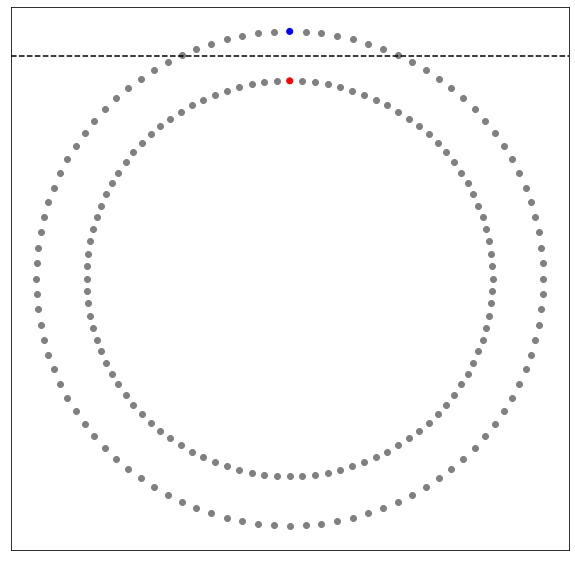

In [14]:
n_unl = 100

n_unl = int(min(n_unl, (n_pat - n_lab) / 2))
plt.figure(figsize=(10, 10))
plt.scatter(X[ind_l, 0], X[ind_l, 1], c=y[ind_l], cmap="bwr")
plt.scatter(X[ind_u0[:n_unl], 0], X[ind_u0[:n_unl], 1], c="gray")
plt.scatter(X[ind_u1[:n_unl], 0], X[ind_u1[:n_unl], 1], c="gray")
plt.plot([-1.1, 1.1], [0.9, 0.9], "--k")
plt.axis([-1.1, 1.1, -1.1, 1.1])
plt.xticks([])
plt.yticks([])
plt.show()

# LapSVM

Code from https://github.com/GuHongyang/LapSVM-python

In [15]:
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

class LapSVM(object):
    def __init__(self,opt):
        self.opt=opt


    def fit(self,X,Y,X_u):
        #construct graph
        self.X=np.vstack([X,X_u])
        Y=np.diag(Y)
        if self.opt['neighbor_mode']=='connectivity':
            W = kneighbors_graph(self.X, self.opt['n_neighbor'], mode='connectivity',include_self=False)
            W = (((W + W.T) > 0) * 1)
        elif self.opt['neighbor_mode']=='distance':
            W = kneighbors_graph(self.X, self.opt['n_neighbor'], mode='distance',include_self=False)
            W = W.maximum(W.T)
            W = sparse.csr_matrix((np.exp(-W.data**2/4/self.opt['t']),W.indices,W.indptr),shape=(self.X.shape[0],self.X.shape[0]))
        else:
            raise Exception()

        # Computing Graph Laplacian
        L = sparse.diags(np.array(W.sum(0))[0]).tocsr() - W

        # Computing K with k(i,j) = kernel(i, j)
        K = self.opt['kernel_function'](self.X,self.X,**self.opt['kernel_parameters'])

        l=X.shape[0]
        u=X_u.shape[0]
        # Creating matrix J [I (l x l), 0 (l x (l+u))]
        J = np.concatenate([np.identity(l), np.zeros(l * u).reshape(l, u)], axis=1)

        # Computing "almost" alpha
        almost_alpha = np.linalg.inv(2 * self.opt['gamma_A'] * np.identity(l + u) \
                                     + ((2 * self.opt['gamma_I']) / (l + u) ** 2) * L.dot(K)).dot(J.T).dot(Y)

        # Computing Q
        Q = Y.dot(J).dot(K).dot(almost_alpha)
        Q = (Q+Q.T)/2

        del W, L, K, J

        e = np.ones(l)
        q = -e

        # ===== Objectives =====
        def objective_func(beta):
            return (1 / 2) * beta.dot(Q).dot(beta) + q.dot(beta)

        def objective_grad(beta):
            return np.squeeze(np.array(beta.T.dot(Q) + q))

        # =====Constraint(1)=====
        #   0 <= beta_i <= 1 / l
        bounds = [(0, 1 / l) for _ in range(l)]

        # =====Constraint(2)=====
        #  Y.dot(beta) = 0
        def constraint_func(beta):
            return beta.dot(np.diag(Y))

        def constraint_grad(beta):
            return np.diag(Y)

        cons = {'type': 'eq', 'fun': constraint_func, 'jac': constraint_grad}

        # ===== Solving =====
        x0 = np.zeros(l)

        beta_hat = minimize(objective_func, x0, jac=objective_grad, constraints=cons, bounds=bounds)['x']

        # Computing final alpha
        self.alpha = almost_alpha.dot(beta_hat)

        del almost_alpha, Q

        # Finding optimal decision boundary b using labeled data
        new_K = self.opt['kernel_function'](self.X,X,**self.opt['kernel_parameters'])
        f = np.squeeze(np.array(self.alpha)).dot(new_K)

        self.sv_ind=np.nonzero((beta_hat>1e-7)*(beta_hat<(1/l-1e-7)))[0]

        ind=self.sv_ind[0]
        self.b=np.diag(Y)[ind]-f[ind]


    def decision_function(self,X):
        new_K = self.opt['kernel_function'](self.X, X, **self.opt['kernel_parameters'])
        f = np.squeeze(np.array(self.alpha)).dot(new_K)
        return f+self.b

def rbf(X1,X2,**kwargs):
    return np.exp(-cdist(X1,X2)**2*kwargs['gamma'])

<div class="tqst">

* For the following example try the values {1, 3, 5} for the variable `l` (the number of labeled points per class). How it affects the different models?
    
* In the case of the LapSVM, try different values for `gamma_I` to see how much it affects to its decision boundary.

</div>

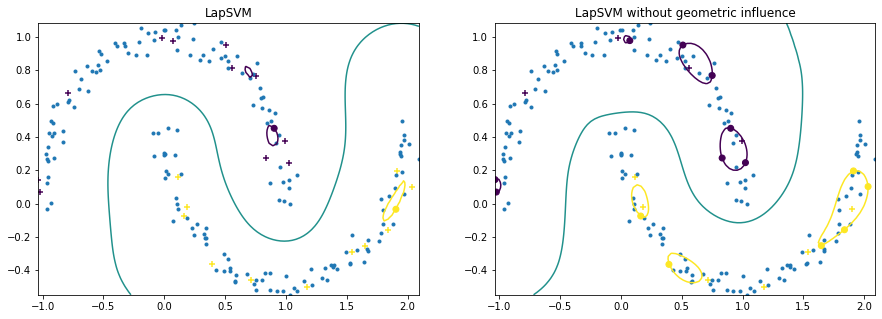

In [23]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
np.random.seed(5)

X, Y = make_moons(n_samples=200, noise=0.05)
ind_0 = np.nonzero(Y == 0)[0]
ind_1 = np.nonzero(Y == 1)[0]
Y[ind_0] = -1

###################################
## VARIABLES:
l = 12
###################################

ind_l0=np.random.choice(ind_0,l,False)
ind_u0=np.setdiff1d(ind_0,ind_l0)

ind_l1 = np.random.choice(ind_1, l, False)
ind_u1 = np.setdiff1d(ind_1, ind_l1)

Xl=np.vstack([X[ind_l0,:],X[ind_l1,:]])
Yl=np.hstack([Y[ind_l0],Y[ind_l1]])
Xu=np.vstack([X[ind_u0,:],X[ind_u1,:]])

######################################
### LapSVM
plt.subplot(1,2,1)
plt.scatter(Xl[:,0],Xl[:,1],marker='+',c=Yl)
plt.scatter(Xu[:,0],Xu[:,1],marker='.')
plt.title('LapSVM')

opt={'neighbor_mode':'connectivity',
        'n_neighbor'   : 5,
        't':            1,
        'kernel_function':rbf,
        'kernel_parameters':{'gamma':10},
        'gamma_A':0.03125,
        'gamma_I':10000}

s=LapSVM(opt)
s.fit(Xl,Yl,Xu)
plt.scatter(Xl[s.sv_ind,0],Xl[s.sv_ind,1],marker='o',c=Yl[s.sv_ind])

Y_=s.decision_function(X)
Y_pre=np.ones(X.shape[0])
Y_pre[Y_<0]=-1

xv, yv = np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),100), np.linspace(X[:,1].min(),X[:,1].max(),100))
XX=s.decision_function(np.hstack([xv.reshape([-1,1]),yv.reshape([-1,1])])).reshape([xv.shape[0],yv.shape[0]])
plt.contour(xv,yv,XX,[-1,0,1])

######################################
### LapSVM without geometry influence
plt.subplot(1,2,2)
plt.scatter(Xl[:, 0], Xl[:, 1], marker='+', c=Yl)
plt.scatter(Xu[:, 0], Xu[:, 1], marker='.')
plt.title('LapSVM without geometric influence')

opt = {'neighbor_mode': 'connectivity',
        'n_neighbor': 5,
        't': 1,
        'kernel_function': rbf,
        'kernel_parameters': {'gamma': 10},
        'gamma_A': 0.03125,
        'gamma_I': 0}

s = LapSVM(opt)
s.fit(Xl, Yl, Xu)
plt.scatter(Xl[s.sv_ind, 0], Xl[s.sv_ind, 1], marker='o', c=Yl[s.sv_ind])

Y_ = s.decision_function(X)
Y_pre = np.ones(X.shape[0])
Y_pre[Y_ < 0] = -1

xv, yv = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
XX = s.decision_function(np.hstack([xv.reshape([-1, 1]), yv.reshape([-1, 1])])).reshape([xv.shape[0], yv.shape[0]])
plt.contour(xv, yv, XX, [-1, 0, 1])
plt.show()